In [9]:
zone_colors = {
    "residential": "#FFD700",  # жёлтый
    "industrial": "#6A5ACD",  # синий в фиолетовый
    "business": "#FF8C00",  # оранжевый
    "recreation": "#ADFF2F",  # светло-зелёный
    "transport": "#A9A9A9",  # серый
    "agriculture": "#20B2AA",  # сине-зелёный
    "special": "#8B4513",  # коричневый
}
zone_translation = {
    "residential": "Жилые зоны",
    "industrial": "Промышленные зоны",
    "business": "Общественно-деловые зоны",
    "recreation": "Рекреационные зоны",
    "transport": "Зоны транспортной инфраструктуры",
    "agriculture": "Зоны сельскохозяйственного назначения",
    "special": "Зоны специального назначения",
}
wrapped_translation = {
    "residential": "Жилые зоны",
    "business": "Общественно-\nделовые зоны",
    "recreation": "Рекреационные зоны",
    "transport": "Зоны транспортной\nинфраструктуры",
    "agriculture": "Зоны\nсельскохозяйственного\nназначения",
    "special": "Зоны специального\nназначения",
    "industrial": "Промышленные зоны",
}

In [6]:
%load_ext autoreload
%autoreload 2

from app.gen_planner.python.src.utils import territory_splitter
from app.gen_planner.python.src import GenPlanner, basic_func_zone, func_zones, terr_zones
import geopandas as gpd
import os
from shapely import Point
import pandas as pd

if os.path.exists("rust_data/conv.csv"):
    os.remove("rust_data/conv.csv")
territory = gpd.read_file('./scenarios_data/project Шлиссельбург.geojson')

middle_lower = Point(31.018, 59.917)
right_upper = Point(31.046, 59.922)
right_lower = Point(31.043, 59.911)
left_upper = Point(30.999, 59.927)
left_lower = Point(30.993, 59.912)

zones_ration = {
    "residential": 0.5714285714285714,
    "business": 0.1142857142857143,
    "recreation": 0.1142857142857143,
    "transport": 0.08571428571428573,
    "special": 0.05714285714285715,
    "agriculture": 0.05714285714285715,
}

fixed_zones = gpd.GeoDataFrame(
    {'zone': [
        "business",
        "recreation",
        "agriculture",
        "special"]},
    geometry=[right_upper, right_lower, left_upper, left_lower],
    crs=4326)

generated_zones, generated_roads = GenPlanner(territory, dev_mod=True).split_features(zones_ratio_dict=zones_ration,
                                                                                      fixed_zones=fixed_zones)

m1 = pd.concat(
    [generated_zones, fixed_zones.rename(columns={'zone': 'zone_name'}).to_crs(generated_zones.crs)]).explore(
    tiles='Cartodb Positron',
    column='zone_name'
    , cmap='Dark2')
# generated_roads.explore(m=m1,column='road_lvl')
m1

2025-04-23 21:05:50.549 | INFO     | app.gen_planner.python.src.genplanner.genplanner:__init__:55 - Dev mod activated, no more ProcessPool


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
True


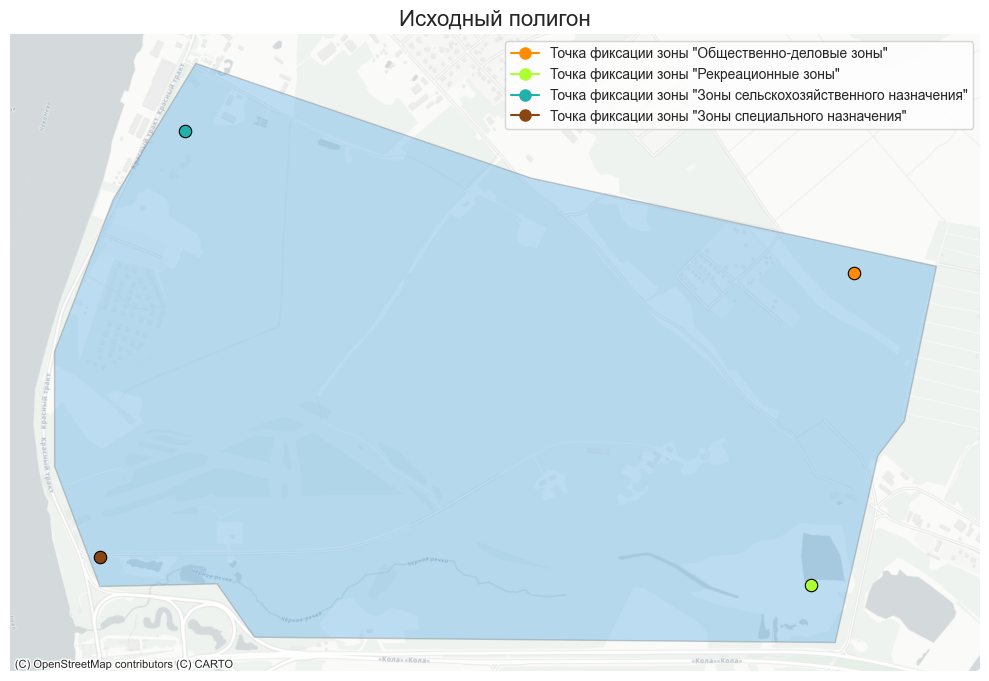

In [21]:
from matplotlib.patches import Patch
import matplotlib.pyplot as plt
import contextily as ctx
from matplotlib.lines import Line2D

# Перевод в Web Mercator (обязательно для contextily)
territory = territory.to_crs(epsg=3857)
fixed_zones = fixed_zones.to_crs(epsg=3857)
# Границы
fig, ax = plt.subplots(figsize=(10, 10))
minx, miny, maxx, maxy = territory.total_bounds
dx, dy = (maxx - minx) * 0.05, (maxy - miny) * 0.05
ax.set_xlim(minx - dx, maxx + dx)
ax.set_ylim(miny - dy, maxy + dy)

# Отображаем базу
ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron, zoom=15)

# Рисуем территорию
territory.plot(ax=ax, facecolor='#61b0e8', edgecolor='gray', alpha=0.4, linewidth=1.0)
legend_elements = []
for zone, color in zone_colors.items():
    p_gdf = fixed_zones[fixed_zones["zone"] == zone]
    if not p_gdf.empty:
        p_gdf.plot(
            ax=ax,
            facecolor=color,
            markersize=80,
            edgecolor='black',
            linewidth=0.8,
        )
        legend_elements.append(Line2D([0], [0], marker='o', color=color, label=f'Точка фиксации зоны \"{zone_translation.get(zone)}\"', markersize=8))

# Легенда и оформление
ax.legend(handles=legend_elements, loc="upper right")
ax.set_axis_off()
ax.set_title("Исходный полигон", fontsize=16)

plt.tight_layout()
plt.savefig("./svetogorsk/shlis_init.png", dpi=200, bbox_inches="tight")
plt.show()


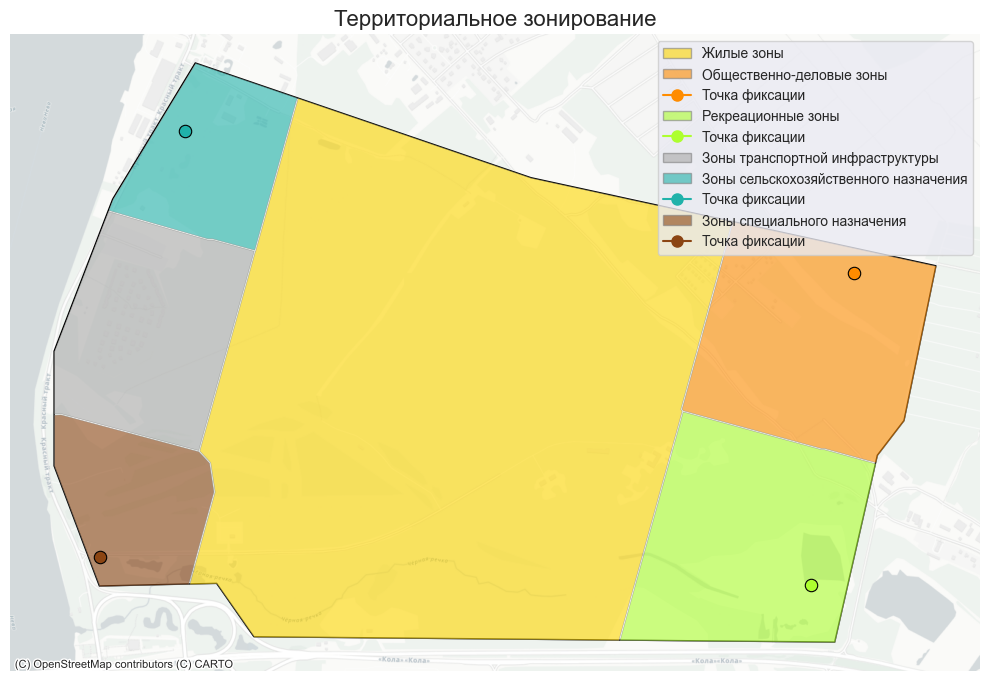

In [18]:
from matplotlib.lines import Line2D

from matplotlib.patches import Patch
import matplotlib.pyplot as plt
import contextily as ctx

# Подготовка
generated_zones['name'] = generated_zones['zone_name']

# Перевод в Web Mercator (обязательно для contextily)
territory = territory.to_crs(epsg=3857)
generated_zones = generated_zones.to_crs(epsg=3857)
fixed_zones = fixed_zones.to_crs(epsg=3857)

# Границы
fig, ax = plt.subplots(figsize=(10, 10))
minx, miny, maxx, maxy = territory.total_bounds
dx, dy = (maxx - minx) * 0.05, (maxy - miny) * 0.05
ax.set_xlim(minx - dx, maxx + dx)
ax.set_ylim(miny - dy, maxy + dy)

# Отображаем базу
ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron, zoom=15)

# Рисуем территорию
territory.plot(ax=ax, edgecolor="black", facecolor="none", linewidth=1.0)

# Зоны + легенда
legend_elements = []
for zone, color in zone_colors.items():
    zone_gdf = generated_zones[generated_zones["name"] == zone]
    if not zone_gdf.empty:
        zone_gdf.plot(
            ax=ax,
            facecolor=color,
            edgecolor='gray',
            linewidth=0.4,
            alpha=0.6,
        )
        legend_elements.append(Patch(facecolor=color, alpha=0.6, edgecolor="gray", label=zone_translation.get(zone)))
    p_gdf = fixed_zones[fixed_zones["zone"] == zone]
    if not p_gdf.empty:
        p_gdf.plot(
            ax=ax,
            facecolor=color,
            markersize=80,
            edgecolor='black',
            linewidth=0.8,
        )
        legend_elements.append(Line2D([0], [0], marker='o', color=color, label='Точка фиксации', markersize=8))

# Легенда и оформление
ax.legend(handles=legend_elements, loc="upper right")
ax.set_axis_off()
ax.set_title("Территориальное зонирование", fontsize=16)

plt.tight_layout()
plt.savefig("./svetogorsk/shlis_zonning.png", dpi=200, bbox_inches="tight")
plt.show()


In [17]:
from PIL import Image, ImageDraw, ImageFont
import os
import numpy as np


def gif_to_collage(gif_path, num_frames=9, output_path="collage.png", grid=None):
    gif = Image.open(gif_path)
    total_frames = gif.n_frames

    # Экспоненциальное распределение индексов кадров
    exp_range = np.logspace(0, 1, num=num_frames, base=40.0) - 1
    print(exp_range)
    exp_range = exp_range / exp_range.max() * (total_frames - 1)
    selected_indices = sorted(set(int(i) for i in exp_range))

    # Гарантировать последний кадр
    if (total_frames - 1) not in selected_indices:
        selected_indices[-1] = total_frames - 1

    frames = []

    font = ImageFont.truetype("arial.ttf", 32)

    for i, frame_idx in enumerate(selected_indices):
        gif.seek(frame_idx)
        frame = gif.copy().convert("RGB")
        draw = ImageDraw.Draw(frame)
        draw.text((30, 20), f"Итерация {frame_idx}", fill="black", font=font)
        frames.append(frame)

    if grid is None:
        # Автоматически определить сетку
        cols = int(num_frames ** 0.5)
        rows = (num_frames + cols - 1) // cols
    else:
        cols, rows = grid

    frame_width, frame_height = frames[0].size
    collage = Image.new("RGB", (cols * frame_width, rows * frame_height), "white")

    for index, frame in enumerate(frames):
        x = (index % cols) * frame_width
        y = (index // cols) * frame_height
        collage.paste(frame, (x, y))
        draw = ImageDraw.Draw(collage)
        draw.rectangle(
            [x, y, x + frame_width - 1, y + frame_height - 1],
            outline="black",
            width=2  # толщина рамки
        )

    collage.save(output_path)
    print(f"Коллаж сохранён в {output_path}")


# Пример использования
gif_to_collage("test.gif", num_frames=9, output_path="collage.png")


[ 0.          0.58583318  1.51486686  2.9881593   5.32455532  9.02968964
 14.90541458 24.2233341  39.        ]
Коллаж сохранён в collage.png


In [11]:
from app.gen_planner.python.src import terr_zones, TerritoryZone

custom_terr_zone = TerritoryZone(
    "custom",
    10_000,
)
territory = gpd.read_file('./scenarios_data/project ШлиссельбургMulti.geojson')
roads = gpd.read_file('./scenarios_data/roads_shlis.geojson')
roads.geometry = roads.to_crs(32636).buffer(2.5).to_crs(4326)
splitted_territory = territory_splitter(territory, roads)
splitted_territory = splitted_territory[~splitted_territory['is_splitter']]
generated_zones, generated_roads = GenPlanner(splitted_territory).features2blocks(custom_terr_zone)

2025-04-21 22:04:37.118 | WARNING  | app.gen_planner.python.src.genplanner.genplanner:features2blocks:128 - territory_zone column not found in working gdf. All geometry's territory zone set to Territory zone "custom"


In [12]:
m1 = generated_zones.explore(column='territory_zone', tiles='CartoDB positron', cmap='Dark2', categorical=True)
generated_roads.explore(m=m1, column='road_lvl', cmap='Dark2', categorical=True)

In [2]:
from shapely import Point
from app.gen_planner.python.src import GenPlanner
import geopandas as gpd
import os

if os.path.exists("./rust_data/conv.csv"):
    print('removed conv')
    os.remove("./rust_data/conv.csv")

territory = gpd.read_file('./scenarios_data/project Шлиссельбург.geojson')
zones_ratio_dict = {'right_lower': 0.225, 'right_upper': 0.225, 'left_upper': 0.225, 'left_lower': 0.225,
                    'middle_lower': 0.1, 'middle_upper': 0.1, 'free_zone1': 0.1, 'free_zone2': 0.1}
fixed_zones = gpd.GeoDataFrame()
middle_lower = Point(31.015, 59.911)
middle_upper = Point(31.022, 59.922)
right_upper = Point(31.046, 59.922)
right_lower = Point(31.043, 59.911)
left_upper = Point(30.999, 59.927)
left_lower = Point(30.993, 59.912)
fixed_2zones = gpd.GeoDataFrame(
    {'zone': ['middle_lower', 'middle_upper']},
    geometry=[middle_lower, middle_upper],
    crs=4326)

fixed_1zone2p = gpd.GeoDataFrame(
    {'zone': ['middle_lower', 'middle_lower']},
    geometry=[middle_lower, middle_upper],
    crs=4326)

fixed_6zones = gpd.GeoDataFrame(
    {'zone': ['middle_lower', 'middle_upper', 'right_upper', 'right_lower', 'left_upper', 'left_lower']},
    geometry=[middle_lower, middle_upper, right_upper, right_lower, left_upper, left_lower],
    crs=4326)

fixed_zones = fixed_6zones

generated_zones, generated_roads = GenPlanner(territory, dev_mod=True).split_features(zones_ratio_dict=zones_ratio_dict,
                                                                                      fixed_zones=fixed_zones)

2025-04-21 22:35:52.637 | INFO     | app.gen_planner.python.src.genplanner.genplanner:__init__:55 - Dev mod activated, no more ProcessPool


removed conv
True


In [ ]:
import pandas as pd

m1 = pd.concat(
    [generated_zones, fixed_zones.rename(columns={'zone': 'zone_name'}).to_crs(generated_zones.crs)]).explore(
    tiles='Cartodb Positron',
    column='zone_name')
# generated_roads.explore(m=m1,column='road_lvl')
m1

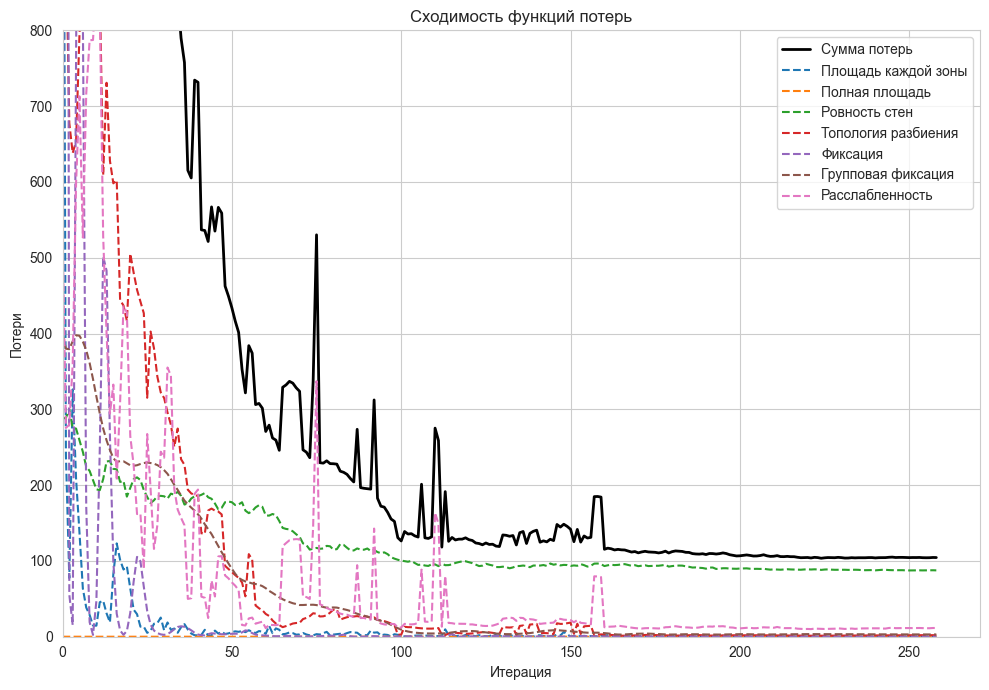

In [19]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid")  # Можешь попробовать "dark", "white", "ticks" и т.д.
# Загрузка данных
df = pd.read_csv("rust_data/conv.csv", header=None, names=[
    "iter", "each_area", "full_area", "wall", "topo", "fix", "lloyd", "group_fix", "lr"
])
df["total"] = df[["each_area", "full_area", "wall", "lloyd", "topo", "group_fix", "fix"]].sum(axis=1)

# Отрисовка графика
plt.figure(figsize=(10, 7))

# Основной total loss
plt.plot(df["iter"], df["total"], label="Сумма потерь", linewidth=2, color="black")

# Остальные компоненты
plt.plot(df["iter"], df["each_area"], label="Площадь каждой зоны", linestyle="--")
plt.plot(df["iter"], df["full_area"], label="Полная площадь", linestyle="--")
plt.plot(df["iter"], df["wall"], label="Ровность стен", linestyle="--")
plt.plot(df["iter"], df["topo"], label="Топология разбиения", linestyle="--")
plt.plot(df["iter"], df["fix"], label="Фиксация", linestyle="--")
plt.plot(df["iter"], df["group_fix"], label="Групповая фиксация", linestyle="--")
plt.plot(df["iter"], df["lloyd"], label="Расслабленность", linestyle="--")

# Оформление
plt.xlabel("Итерация")
plt.ylabel("Потери")
plt.title("Сходимость функций потерь")
plt.legend()
plt.grid(True)
plt.ylim(0, 800)
plt.xlim(left=0)
plt.tight_layout()
plt.savefig("./svetogorsk/Convergence.png", dpi=200, bbox_inches="tight")
plt.show()


In [4]:
df

,iter,each_area,full_area,wall,topo,fix,lloyd,group_fix,lr,total
0,0,2260.446500,0.011921,294.96323,978.876160,0.000000,148.857500,514.970300,0.080000,4198.125611
1,1,993.276000,0.011921,325.45828,1109.026400,4122.282700,49.078976,529.172360,0.080000,7128.306637
2,2,186.096800,0.023842,274.77655,915.741940,31.235970,157.780850,533.902100,0.080000,2099.558052
3,3,95.581900,0.011921,257.95215,914.638060,30.037504,68.221985,545.895100,0.080000,1912.338620
4,4,156.122440,0.017881,282.87115,899.191100,1265.157200,103.038700,552.587300,0.080000,3258.985771
...,...,...,...,...,...,...,...,...,...,...
243,243,0.489076,0.017881,158.07254,0.316588,0.382354,7.733440,15.176682,0.002174,182.188560
244,244,0.485456,0.017881,158.06430,0.315959,0.359668,7.723412,15.184737,0.002112,182.151413
245,245,0.484402,0.011921,158.02603,0.312657,0.333627,7.815383,15.167812,0.002063,182.151832
246,246,0.486846,0.011921,158.04440,0.312427,0.308564,7.827708,15.134275,0.002028,182.126141


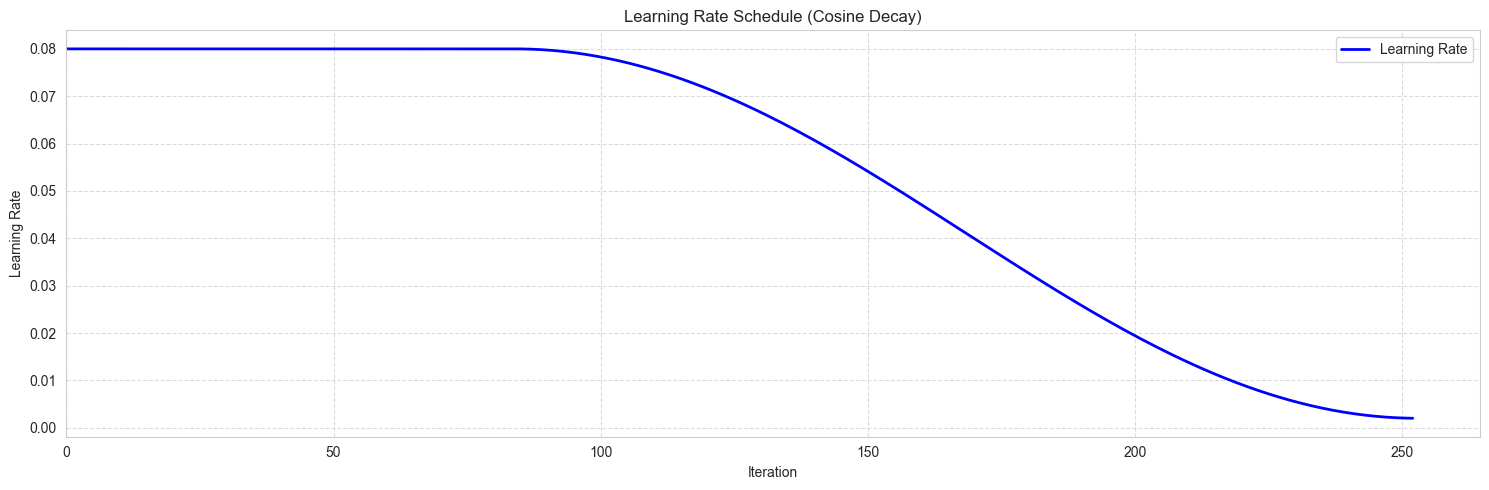

In [32]:
plt.figure(figsize=(15, 5))
plt.plot(df["iter"], df["lr"], label="Learning Rate", color="blue", linewidth=2)
plt.xlabel("Iteration")
plt.ylabel("Learning Rate")
plt.title("Learning Rate Schedule (Cosine Decay)")
plt.grid(True, linestyle="--", alpha=0.7)
plt.xlim(left=0)
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
roads.geometry = roads.to_crs(32636).buffer(2).to_crs(4326)
splitted_zones = territory_splitter(generated_zones, roads)
splitted_zones[~splitted_zones['is_splitter']].explore(tiles='Cartodb Positron')

In [ ]:
splitted_territory.explore(tiles='Cartodb Positron')

In [ ]:
from app.gen_planner.python.src import GenPlanner, basic_func_zone, func_zones
import geopandas as gpd

zones, roads = GenPlanner(gpd.read_file('project Шлиссельбург.geojson')).poly2terr2block(basic_func_zone)
m1 = zones.explore(column='terr_zone', tiles='CartoDB positron', cmap='Dark2', categorical=True)
roads.explore(m=m1, column='road_lvl', cmap='Dark2', categorical=True)

In [ ]:
%load_ext autoreload
%autoreload 2

from app.gen_planner.python.src.utils import territory_splitter
from app.gen_planner.python.src import GenPlanner, basic_func_zone, func_zones
import geopandas as gpd

territory = gpd.read_file('project Шлиссельбург.geojson')
roads = gpd.read_file('roads_shlis.geojson')
roads.geometry = roads.to_crs(32636).buffer(5).to_crs(4326)
splitted_territory = territory_splitter(territory, roads)
splitted_territory = splitted_territory[~splitted_territory['is_splitter']].reset_index(drop=True)
generated_zones, generated_roads = GenPlanner(splitted_territory, dev_mod=True).features2terr_zones2block(
    func_zones.residential_func_zone)

m1 = generated_zones.explore(column='territory_zone', tiles='CartoDB positron', cmap='Dark2', categorical=True)
generated_roads.explore(m=m1, column='road_lvl', cmap='Dark2', categorical=True)

In [ ]:
generated_zones[generated_zones['proxy'].isna()].explore(column='territory_zone', tiles='CartoDB positron',
                                                         cmap='Dark2', categorical=True)


In [ ]:
generated_zones[generated_zones['proxy'] == 1].explore(column='zone_name')

In [ ]:
splitted_territory.explore()

In [ ]:
territory = gpd.read_file('project Шлиссельбург.geojson')
# roads = gpd.read_file('roads_shlis.geojson')
# roads.geometry = roads.to_crs(32636).buffer(5).to_crs(4326)
# splitted_territory = territory_splitter(territory, roads)
# splitted_territory = splitted_territory[~splitted_territory['is_splitter']].reset_index(drop=True)
generated_zones, generated_roads = GenPlanner(territory, dev_mod=True).features2terr_zones2block(
    func_zones.residential_func_zone)

m1 = generated_zones.explore(column='territory_zone', tiles='CartoDB positron', cmap='Dark2', categorical=True)
generated_roads.explore(m=m1, column='road_lvl', cmap='Dark2', categorical=True)